In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BASE_PATH = '/content/drive/My Drive'
BALANCED5k_PATH = os.path.join(BASE_PATH, 'balanced5k.csv') # old one
BALANCED4k_PATH = os.path.join(BASE_PATH, 'balanced4k.csv') # old one
BALANCEDnk_PATH = os.path.join(BASE_PATH, 'balancednk.csv') # after latest augmentation (best for now)
PATH_DEV_NODUP = os.path.join(BASE_PATH, 'fer_dev_nodup.csv')
PATH_TEST_NODUP = os.path.join(BASE_PATH, 'fer_test_nodup.csv')

# 0. The data

In [4]:
# 1408 balanced data
df = pd.read_csv('/content/drive/My Drive/balanced_1408.csv').drop(columns=['Unnamed: 0'])
df.emotion.value_counts()

6    5000
5    5000
4    5000
3    5000
2    5000
0    5000
1    2292
Name: emotion, dtype: int64

In [5]:
df.shape

(32292, 2305)

And let's just plot some picture

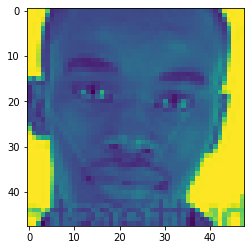

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.array(df.iloc[-10,1:]).reshape(48,48)) #synthetic

# 1. Time for NNs setup! :) 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import argparse
from collections import OrderedDict
from xgboost import XGBClassifier

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### Deep Learning models ###
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D
#from tensorflow. keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import densenet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

import time

We will use PublicTest data as dev set. All datasets were created & preprocessed in notebook fer_preprocess_augment_balance.ipynb

In [9]:
# first, prepare the data

# two versions of train data 
X_train, y_train = df.drop(columns=['emotion']), df.emotion.values

# dev set that we will use here as test
fer_dev = pd.read_csv(PATH_DEV_NODUP).drop(columns=['Unnamed: 0'])
X_test, y_test = fer_dev.drop(columns=['emotion']), fer_dev.emotion.values

shape_x = 48
shape_y = 48

# reshape
X_train = X_train.values.reshape(-1, 48, 48, 1)
X_test = X_test.values.reshape(-1, 48, 48, 1)

# rescale, almost doesn't affect performace
#X_train = X_train / X_train.max()
#X_test = X_test / X_test.max()

# check out shapes
print(f'Train data has shape: {X_train.shape}, and test data is of shape: {X_test.shape}')

# define some consts
input_shape = X_train.shape[1:]
classes = np.unique(y_train)
nClasses = len(classes)
print(f'Input shape: {input_shape}, and target classes: {classes}')

Train data has shape: (32292, 48, 48, 1), and test data is of shape: (3293, 48, 48, 1)
Input shape: (48, 48, 1), and target classes: [0 1 2 3 4 5 6]


In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Now, when we are all set, let's move to our first cnn

But first prepare plotting functions to visualize accuracy and loss of models on train and test sets

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def plot_accuracy(history, title=f'accuracy for train and val'):
    plt.figure(figsize=(15,4))
    plt.plot(np.arange(1, len(history.history['accuracy'])+ 1), history.history['accuracy'],'r', label='accuracy')
    plt.plot(np.arange(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'],'b', label = 'val_accuracy')
    best_val_acc = round(max(history.history['val_accuracy']), 5)
    plt.scatter(np.argmax(list(history.history['val_accuracy']))+1, max(history.history['val_accuracy']), c='magenta',
               label=f'highest val_accuracy: {best_val_acc}')
    plt.xlabel('epoch')
    plt.ylabel('accuracy score')
    plt.ylim([0, 1])
    plt.xlim([1, len(history.history['accuracy'])+1])
    plt.title(title)
    plt.legend()
    plt.show()


def plot_loss(history, title=f'losses for train and val'):
    plt.figure(figsize=(15,4))
    plt.plot(np.arange(1, len(history.history['loss'])+ 1), history.history['loss'],'r', label='loss')
    plt.plot(np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'],'b', label = 'val_loss')
    best_val_loss = round(min(history.history['val_loss']), 5)
    plt.scatter(np.argmin(list(history.history['val_loss']))+1, min(history.history['val_loss']), c='magenta',
               label=f'lowest val_loss: {best_val_loss}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim([0, 5])
    plt.xlim([1, len(history.history['loss'])+1])
    plt.title(title)
    plt.legend()
    plt.show()

# 2. CNN

In [10]:
def createcnn0():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))

    model.add(Dense(nClasses))
    model.add(Activation('softmax'))
    return model


In [11]:
cnn0 = createcnn0()
cnn0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 100

mcp_save = ModelCheckpoint('cnn0_100.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, verbose=1, min_delta=1e-4, mode='max')



history_cnn_0_100 = cnn0.fit(
    X_train, y_train, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_data=(X_test, y_test),
   callbacks=[mcp_save, reduce_lr_acc]) 

Epoch 1/100
1010/1010 [==============================] - 10s 9ms/step - loss: 1.6845 - accuracy: 0.3406 - val_loss: 1.4918 - val_accuracy: 0.4239
Epoch 2/100
1010/1010 [==============================] - 9s 9ms/step - loss: 1.3766 - accuracy: 0.4677 - val_loss: 1.4326 - val_accuracy: 0.4522
Epoch 3/100
1009/1010 [============================>.] - ETA: 0s - loss: 1.2622 - accuracy: 0.5103
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
1010/1010 [==============================] - 9s 9ms/step - loss: 1.2623 - accuracy: 0.5103 - val_loss: 1.3653 - val_accuracy: 0.4862
Epoch 4/100
1010/1010 [==============================] - 9s 9ms/step - loss: 1.1473 - accuracy: 0.5557 - val_loss: 1.1387 - val_accuracy: 0.5572
Epoch 5/100
1008/1010 [============================>.] - ETA: 0s - loss: 1.0726 - accuracy: 0.5853
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
1010/1010 [==============================] - 9s 9ms/step - loss: 1.0726 -

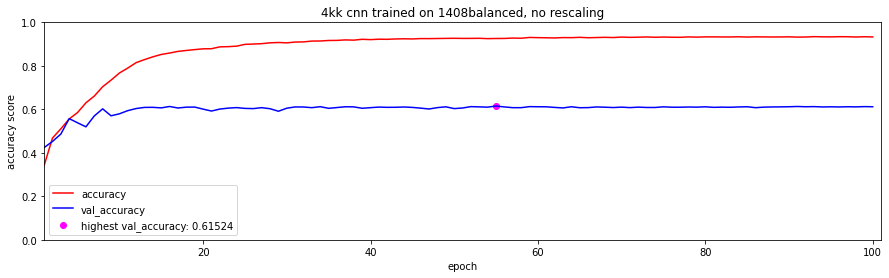

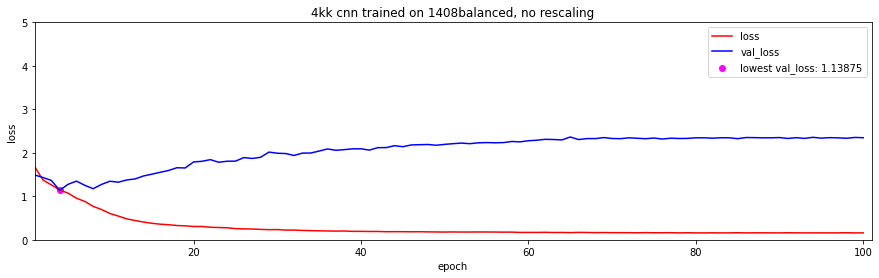

In [12]:
plot_accuracy(history_cnn_0_100, title='4kk cnn trained on 1408balanced, no rescaling')
plot_loss(history_cnn_0_100, title='4kk cnn trained on 1408balanced, no rescaling')

In [13]:
cnn0_60_resc = createcnn0()
cnn0_60_resc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 60

mcp_save = ModelCheckpoint('cnn0_60_resc.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, verbose=1, min_delta=1e-4, mode='max')



history_cnn0_60_resc = cnn0_60_resc.fit(
    X_train/255, y_train, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_data=(X_test/255, y_test),
   callbacks=[mcp_save, reduce_lr_acc]) 

Epoch 1/60
1010/1010 [==============================] - 9s 9ms/step - loss: 1.6929 - accuracy: 0.3427 - val_loss: 1.3813 - val_accuracy: 0.4649
Epoch 2/60
1010/1010 [==============================] - 9s 9ms/step - loss: 1.3904 - accuracy: 0.4604 - val_loss: 1.3795 - val_accuracy: 0.4537
Epoch 3/60
1010/1010 [==============================] - 9s 9ms/step - loss: 1.2680 - accuracy: 0.5109 - val_loss: 1.4055 - val_accuracy: 0.4552
Epoch 4/60
1010/1010 [==============================] - 9s 9ms/step - loss: 1.1797 - accuracy: 0.5419 - val_loss: 1.2557 - val_accuracy: 0.5269
Epoch 5/60
1008/1010 [============================>.] - ETA: 0s - loss: 1.1058 - accuracy: 0.5739
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
1010/1010 [==============================] - 9s 9ms/step - loss: 1.1059 - accuracy: 0.5740 - val_loss: 1.1804 - val_accuracy: 0.5557
Epoch 6/60
1010/1010 [==============================] - 9s 9ms/step - loss: 0.9932 - accuracy: 0.6164 - val_loss:

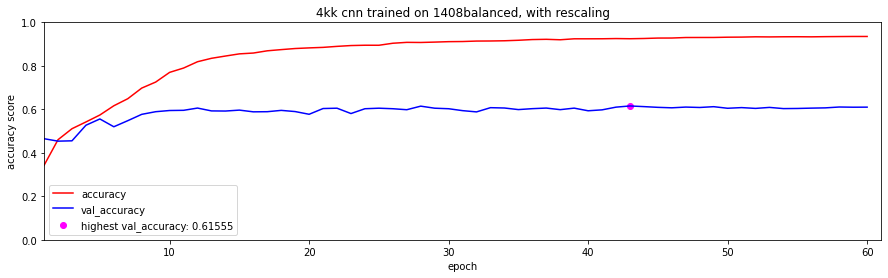

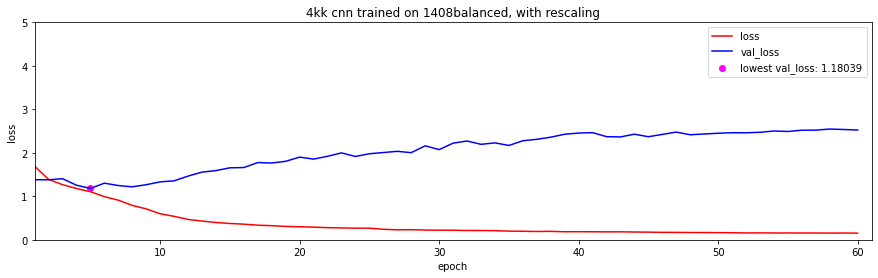

In [14]:
plot_accuracy(history_cnn0_60_resc, title='4kk cnn trained on 1408balanced, with rescaling')
plot_loss(history_cnn0_60_resc, title='4kk cnn trained on 1408balanced, with rescaling')

ehhh, not trained enough((

# 3. Larger CNN

In [19]:
def createcnn1():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.1))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))
    
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.15))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.25))

    model.add(Dense(nClasses))
    model.add(Activation('softmax'))

    return model


In [16]:
cnn1_100 = createcnn1()
cnn1_100.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 100

mcp_save = ModelCheckpoint('cnn1_100.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, verbose=1, min_delta=1e-4, mode='max')


history_cnn1_100 = cnn1_100.fit(
    X_train, y_train, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_data=(X_test, y_test),
   callbacks=[mcp_save, reduce_lr_acc])

Epoch 1/100
1010/1010 [==============================] - 12s 12ms/step - loss: 1.6684 - accuracy: 0.3407 - val_loss: 1.5786 - val_accuracy: 0.3996
Epoch 2/100
1010/1010 [==============================] - 11s 11ms/step - loss: 1.3799 - accuracy: 0.4635 - val_loss: 1.3025 - val_accuracy: 0.4998
Epoch 3/100
1006/1010 [============================>.] - ETA: 0s - loss: 1.2552 - accuracy: 0.5183
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
1010/1010 [==============================] - 12s 11ms/step - loss: 1.2555 - accuracy: 0.5184 - val_loss: 1.2770 - val_accuracy: 0.5026
Epoch 4/100
1010/1010 [==============================] - 12s 11ms/step - loss: 1.1419 - accuracy: 0.5578 - val_loss: 1.2095 - val_accuracy: 0.5320
Epoch 5/100
1009/1010 [============================>.] - ETA: 0s - loss: 1.0627 - accuracy: 0.5900
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
1010/1010 [==============================] - 11s 11ms/step - loss:

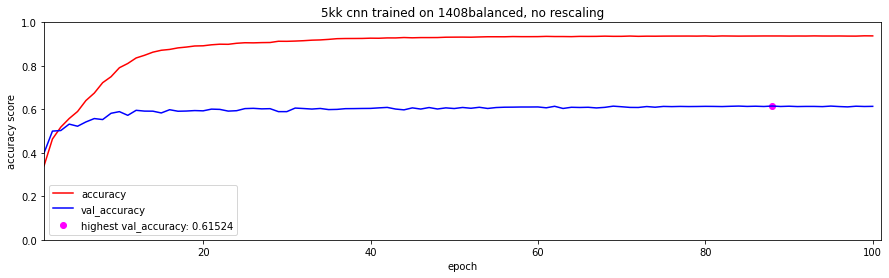

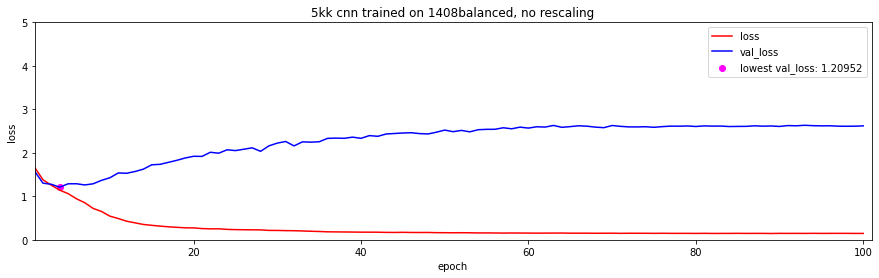

In [17]:
plot_accuracy(history_cnn1_100, title='5kk cnn trained on 1408balanced, no rescaling')
plot_loss(history_cnn1_100, title='5kk cnn trained on 1408balanced, no rescaling')

In [18]:
cnn1_adam = createcnn1()
cnn1_adam.compile(optimizer=tensorflow.keras.optimizers.Adam(
      learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 100

mcp_save = ModelCheckpoint('cnn1_adam.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, verbose=1, min_delta=1e-4, mode='max')


history_cnn1_adam = cnn1_adam.fit(
    X_train, y_train, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_data=(X_test, y_test),
   callbacks=[mcp_save, reduce_lr_acc])

Epoch 1/100
1010/1010 [==============================] - 12s 12ms/step - loss: 1.7772 - accuracy: 0.2952 - val_loss: 1.5281 - val_accuracy: 0.4009
Epoch 2/100
1010/1010 [==============================] - 11s 11ms/step - loss: 1.4664 - accuracy: 0.4327 - val_loss: 1.4960 - val_accuracy: 0.4236
Epoch 3/100
1009/1010 [============================>.] - ETA: 0s - loss: 1.3159 - accuracy: 0.4954
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0034999999217689036.
1010/1010 [==============================] - 11s 11ms/step - loss: 1.3159 - accuracy: 0.4954 - val_loss: 1.2563 - val_accuracy: 0.5105
Epoch 4/100
1010/1010 [==============================] - 11s 11ms/step - loss: 1.1895 - accuracy: 0.5415 - val_loss: 1.2617 - val_accuracy: 0.5181
Epoch 5/100
1010/1010 [==============================] - ETA: 0s - loss: 1.1064 - accuracy: 0.5730
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0024499999126419425.
1010/1010 [==============================] - 11s 11ms/step - loss:

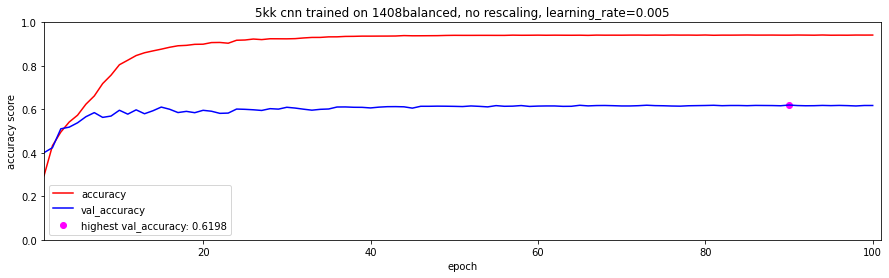

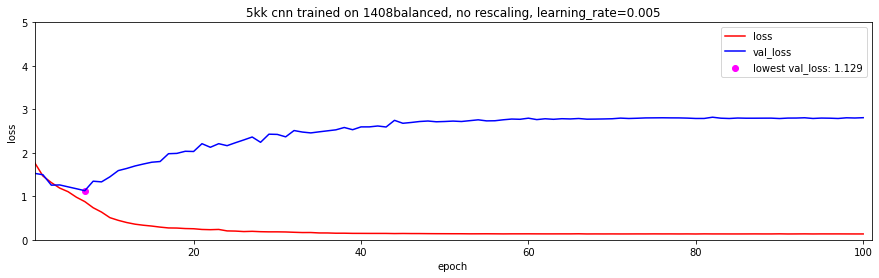

In [19]:
# history_cnn1_adam
plot_accuracy(history_cnn1_adam, title='5kk cnn trained on 1408balanced, no rescaling, learning_rate=0.005')
plot_loss(history_cnn1_adam, title='5kk cnn trained on 1408balanced, no rescaling, learning_rate=0.005')

In [20]:
cnn1_adam_amsgrad = createcnn1()
cnn1_adam_amsgrad.compile(optimizer=tensorflow.keras.optimizers.Adam(
      learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True), loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 100

mcp_save = ModelCheckpoint('cnn1_adam_amsgrad.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, verbose=1, min_delta=1e-4, mode='max')


history_cnn1_adam_amsgrad = cnn1_adam_amsgrad.fit(
    X_train, y_train, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_data=(X_test, y_test),
   callbacks=[mcp_save, reduce_lr_acc])

Epoch 1/100
1010/1010 [==============================] - 13s 12ms/step - loss: 1.7987 - accuracy: 0.2738 - val_loss: 1.5349 - val_accuracy: 0.3814
Epoch 2/100
1010/1010 [==============================] - 12s 12ms/step - loss: 1.4836 - accuracy: 0.4196 - val_loss: 1.3308 - val_accuracy: 0.4923
Epoch 3/100
1008/1010 [============================>.] - ETA: 0s - loss: 1.3313 - accuracy: 0.4846
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0034999999217689036.
1010/1010 [==============================] - 12s 12ms/step - loss: 1.3312 - accuracy: 0.4845 - val_loss: 1.3395 - val_accuracy: 0.4762
Epoch 4/100
1010/1010 [==============================] - 12s 12ms/step - loss: 1.1937 - accuracy: 0.5362 - val_loss: 1.2510 - val_accuracy: 0.5217
Epoch 5/100
1008/1010 [============================>.] - ETA: 0s - loss: 1.1087 - accuracy: 0.5686
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0024499999126419425.
1010/1010 [==============================] - 12s 12ms/step - loss:

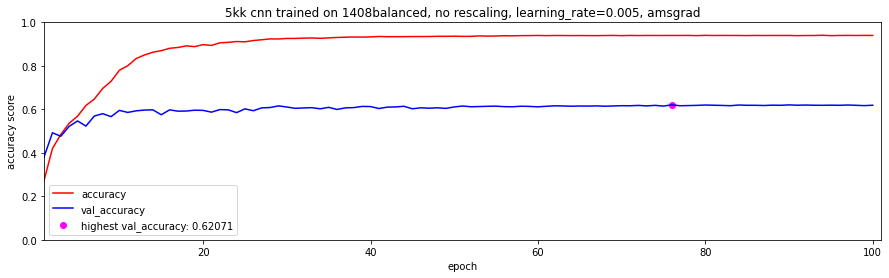

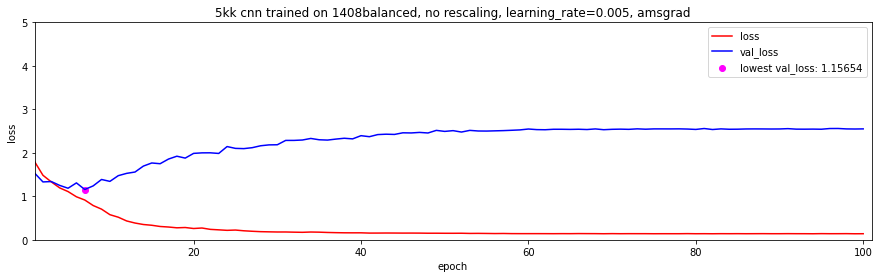

In [23]:
plot_accuracy(history_cnn1_adam_amsgrad, title='5kk cnn trained on 1408balanced, no rescaling, learning_rate=0.005, amsgrad')
plot_loss(history_cnn1_adam_amsgrad, title='5kk cnn trained on 1408balanced, no rescaling, learning_rate=0.005, amsgrad')

In [23]:
# print(f'After reaching max, val accuracy oscillated around: {np.mean(history_cnn_11.history["val_accuracy"][np.argmax(list(history_cnn_11.history["val_accuracy"])):])}')

After reaching max, val accuracy oscillated around: 0.6331742902596792


# 4. VGG! :) 

In [12]:
def create_vgg16():
    img_input = Input(shape=(shape_x,shape_y,1))

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = MaxPooling2D((2, 2), strides=None, name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=None, name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=None, name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=None, name='pool4')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=None, name='pool5')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, name='fc6')(x)
    x = Dense(7, name='fc11')(x)
    x = Activation('softmax', name='fc11/softmax')(x)

    model = Model(img_input, x, name='vggface_vgg16')
    return model


In [13]:
vgg_16_100_rsc = create_vgg16()
vgg_16_100_rsc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 100

mcp_save = ModelCheckpoint('vgg_16_100_rsc.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, verbose=1, min_delta=1e-4, mode='max')


history_vgg_16_100_rsc = vgg_16_100_rsc.fit(
    X_train/255, y_train, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_data=(X_test/255, y_test),
   callbacks=[mcp_save, reduce_lr_acc])


Epoch 1/100
1010/1010 [==============================] - 28s 28ms/step - loss: 1.8412 - accuracy: 0.2816 - val_loss: 1.8019 - val_accuracy: 0.2636
Epoch 2/100
1010/1010 [==============================] - 28s 27ms/step - loss: 1.4920 - accuracy: 0.4048 - val_loss: 1.3954 - val_accuracy: 0.4661
Epoch 3/100
1008/1010 [============================>.] - ETA: 0s - loss: 1.3583 - accuracy: 0.4725
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
1010/1010 [==============================] - 27s 27ms/step - loss: 1.3583 - accuracy: 0.4726 - val_loss: 1.6372 - val_accuracy: 0.3756
Epoch 4/100
1010/1010 [==============================] - 28s 27ms/step - loss: 1.2256 - accuracy: 0.5249 - val_loss: 1.2241 - val_accuracy: 0.5384
Epoch 5/100
1009/1010 [============================>.] - ETA: 0s - loss: 1.1543 - accuracy: 0.5543
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
1010/1010 [==============================] - 28s 27ms/step - loss:

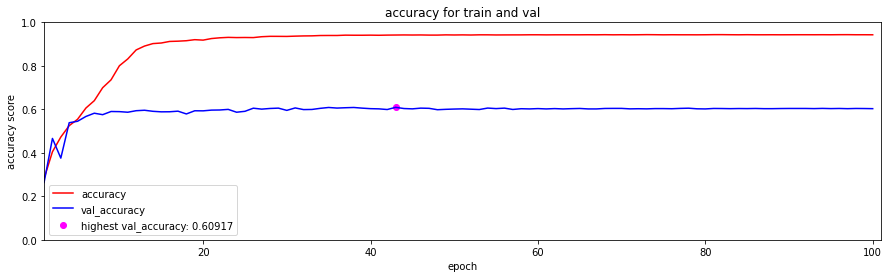

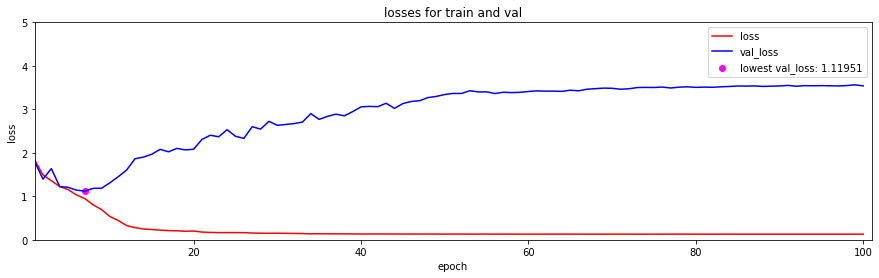

In [14]:
# history_vgg_16_100_rsc
plot_accuracy(history_vgg_16_100_rsc, title)
plot_loss(history_vgg_16_100_rsc)

In [15]:
vgg_16_100_rsc_ma = create_vgg16()
vgg_16_100_rsc_ma.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 32
epochs = 50

mcp_save = ModelCheckpoint('vgg_16_100_rsc_ma.h5', save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.7, patience=2, verbose=1, min_delta=1e-4, mode='max')


history_vgg_16_100_rsc_ma = vgg_16_100_rsc_ma.fit(
    X_train/255, y_train, 
    epochs = epochs, 
    batch_size=batch_size,
   validation_data=(X_test/255, y_test),
   callbacks=[mcp_save, reduce_lr_acc])


Epoch 1/50
1010/1010 [==============================] - 28s 28ms/step - loss: 1.8750 - accuracy: 0.2558 - val_loss: 1.6649 - val_accuracy: 0.3000
Epoch 2/50
1010/1010 [==============================] - 28s 27ms/step - loss: 1.5326 - accuracy: 0.3940 - val_loss: 1.4182 - val_accuracy: 0.4646
Epoch 3/50
1010/1010 [==============================] - 28s 27ms/step - loss: 1.3905 - accuracy: 0.4575 - val_loss: 1.3345 - val_accuracy: 0.4971
Epoch 4/50
1010/1010 [==============================] - 28s 28ms/step - loss: 1.2974 - accuracy: 0.4960 - val_loss: 1.2211 - val_accuracy: 0.5363
Epoch 5/50
1010/1010 [==============================] - 28s 28ms/step - loss: 1.2430 - accuracy: 0.5212 - val_loss: 1.1988 - val_accuracy: 0.5466
Epoch 6/50
1010/1010 [==============================] - 28s 27ms/step - loss: 1.1545 - accuracy: 0.5601 - val_loss: 1.6658 - val_accuracy: 0.4136
Epoch 7/50
1009/1010 [============================>.] - ETA: 0s - loss: 1.0895 - accuracy: 0.5822
Epoch 00007: ReduceLROnPla

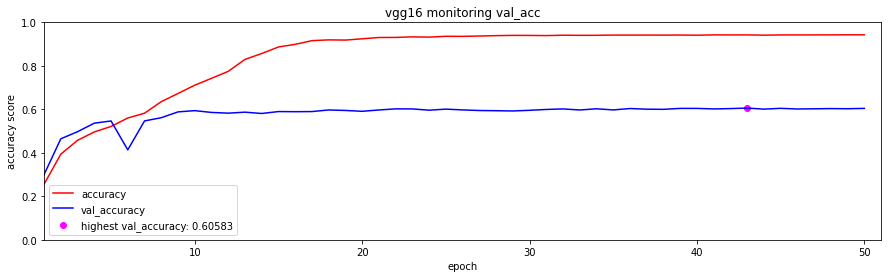

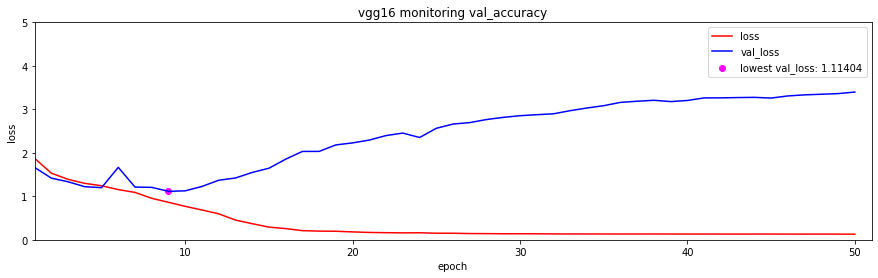

In [16]:
plot_accuracy(history_vgg_16_100_rsc_ma, title='vgg16 monitoring val_acc')
plot_loss(history_vgg_16_100_rsc_ma, title ='vgg16 monitoring val_accuracy')

# 5. Summing up

We tried two CNNs and changed VGG16. All NNs were trained on balanced_1408.csv dataset which had 5000 images in each class except 1, for label 1 - almost 2300 images. The best model provided 62% accuracy on dev set (or PublicTest). So, let's test on PrivateTest which was never used to train/evaluate the models

In [24]:
private_test = pd.read_csv(PATH_TEST_NODUP).drop('Unnamed: 0', axis=1)
X_pt, y_pt = private_test.drop('emotion', axis=1), private_test.emotion.values
X_pt = X_pt.values.reshape(-1, 48, 48, 1)
y_pt = to_categorical(y_pt)

In [25]:
model = createcnn1()
# Loading weights from saved model
model.load_weights('/content/cnn1_adam_amsgrad.h5')
model.compile(optimizer=tensorflow.keras.optimizers.Adam(
      learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True), loss='categorical_crossentropy', metrics=['accuracy'])
 
# Evaluate it
loss, acc = model.evaluate(X_pt, y_pt, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

103/103 [==============================] - 1s 5ms/step - loss: 2.4668 - accuracy: 0.6270
Restored model, accuracy: 62.70%
